In [195]:
import pandas as pd
import numpy as np
df = pd.read_csv('hotel_bookings.csv')
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [196]:
#combining date columns into a single pandas date time format 
df['date'] =pd.to_datetime(df.arrival_date_year.astype(str) + df.arrival_date_month.astype(str) + df.arrival_date_day_of_month.astype(str), format='%Y%B%d')
df['date'].dtype #data frame now contains a pandas date time format date column

dtype('<M8[ns]')

In [197]:
df = df.drop(['hotel', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'], axis=1)

# Extracting 2017 Observations

In [198]:
#Let's only explore datapoints in 2017 population
df = df.loc[(df['date'] >= '2017-01-01')& (df['date'] <= '2017-12-31')]
df.count()

is_canceled    40687
adr            40687
date           40687
dtype: int64

# Extract a Random Sample 10% of Observations

In [199]:
#extract a random sample of 4068 for a two sample z test for comapring means
df = df.sample(n=4068, random_state=50)

Check for skewness for canceled average daily rates

Canceled bookings skewness: 0.9350625746091727


<AxesSubplot:>

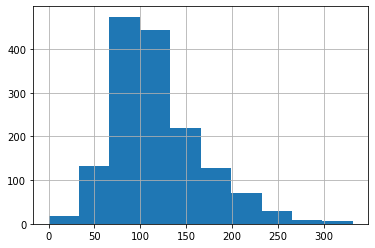

In [200]:
#check for outliers/skewness in our dataset for canceled bookings
print('Canceled bookings skewness:', df[df.is_canceled==1].adr.skew())
df[df.is_canceled==1].adr.hist()

Check for skewness for canceled average daily rates

Canceled bookings skewness: 0.8272397158448642


<AxesSubplot:>

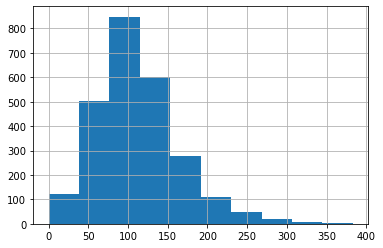

In [201]:
#check for outliers/skewness in our dataset for not canceled bookings
print('Canceled bookings skewness:', df[df.is_canceled==0].adr.skew())
df[df.is_canceled==0].adr.hist()

Let's remove outliers from both canceled and not canceled samples

# Removing Outliers for Canceled Bookings

In [202]:
#Since skewness is higher than moderate let's remove any outliers using box plot calculations
#Canceled bookings outliers
df.sort_values("adr")
q1_canceled, q3_canceled= np.percentile(df[df.is_canceled==1].adr,[25,75])
print('Q1:', q1_canceled)
print('Q3:',q3_canceled)

Q1: 85.165
Q3: 140.825


In [203]:
iqr_canceled = q3_canceled - q1_canceled
iqr_canceled

55.65999999999998

In [204]:
lower_bound_canceled = q1_canceled -(1.5 * iqr_canceled)
upper_bound_canceled = q3_canceled +(1.5 * iqr_canceled)

print('Lower Bound_canceled:', lower_bound_canceled)
print('Upper Bound_canceled:', upper_bound_canceled)


Lower Bound_canceled: 1.6750000000000256
Upper Bound_canceled: 224.31499999999997


# Removing Outliers for Non Canceled Bookings

In [205]:
##Since skewness is higher than moderate let's remove any outliers using box plot calculations
#Not Canceled bookings outliers
q1_not_canceled, q3_not_canceled= np.percentile(df[df.is_canceled==0].adr,[25,75])
print('Q1:', q1_not_canceled)
print('Q3:',q3_not_canceled)

iqr_not_canceled = q3_not_canceled - q1_not_canceled

lower_bound_not_canceled = q1_not_canceled -(1.5 * iqr_not_canceled)
upper_bound_not_canceled = q3_not_canceled +(1.5 * iqr_not_canceled)

print('Lower Bound_not_canceled:', lower_bound_not_canceled)
print('Upper Bound_not_canceled:', upper_bound_not_canceled)



Q1: 78.0
Q3: 140.0
Lower Bound_not_canceled: -15.0
Upper Bound_not_canceled: 233.0


# Creating a New Dataframe Excluding Outliers

In [206]:
#canceled_filter = df[df.is_canceled==1]
#df['adr_cleaned']=canceled_filter.adr[df.adr <0]
df1 = df[(df.is_canceled==1) & (df.adr>lower_bound_canceled) & (df.adr<upper_bound_canceled)]
df2 = df[(df.is_canceled==0) & (df.adr>lower_bound_not_canceled) & (df.adr<upper_bound_not_canceled)]

df = pd.concat([df1, df2], ignore_index=True)
df



,is_canceled,adr,date
0,1,100.00,2017-04-26
1,1,130.00,2017-05-30
2,1,122.67,2017-06-15
3,1,218.00,2017-07-31
4,1,74.80,2017-03-27
...,...,...,...
3929,0,60.00,2017-04-04
3930,0,165.33,2017-07-28
3931,0,160.00,2017-08-18
3932,0,138.00,2017-05-14


Skewness is now much lower than before and we can run a Z-test to compare means

In [207]:
#Now we can see that skewness is much lower compared to before
print('Canceled bookings skewness:', df[df.is_canceled==1].adr.skew())
print('Not_Canceled bookings skewness:', df[df.is_canceled==0].adr.skew())

Canceled bookings skewness: 0.4388423472558201
Not_Canceled bookings skewness: 0.3106972439564341


# Z-test for Comparing Means

Assumptions of test:

The samples from each population must be independent of
one another.

The populations from which the samples are taken must be
normally distributed and the population standard
deviations must be known, or the sample sizes must be large
(i.e. n1≥30 and n2≥30.

# Hypothesis:

Null Hypothesis: The difference between the means of average daily rate for canceled and not canceled bookings is 0

Alternative Hypothesis:  The difference between the means of average daily rate for canceled and not canceled bookings NOT 0


In [208]:
import statsmodels.stats.weightstats as ws
not_canceled_adr = ws.DescrStatsW(df[df.is_canceled==0].adr)
canceled_adr = ws.DescrStatsW(df[df.is_canceled==1].adr)

In [209]:
cm_obj = ws.CompareMeans(canceled_adr, not_canceled_adr)
zstat, z_pval = cm_obj.ztest_ind(value=0)
print(zstat.round(4), z_pval)

3.2164 0.001298129425537898


In [210]:
#We can conclude that means for the average daily rate for canceled and not canceled bookings are signficantly different 
#Average daily rate is a factor for whether a booking may be canceled or not

print('Canceled bookings Mean:', df[df.is_canceled==1].adr.mean())
print('Not_Canceled bookings Mean:', df[df.is_canceled==0].adr.mean())

Canceled bookings Mean: 112.79073921971266
Not_Canceled bookings Mean: 108.10921148402781


# Conclusion:

Bookings that were canceled had an average daily rate significantly higher than non canceled bookings (Z= 3.21, n1(canceled) =1461, n2(not_canceled)=2473, p<.05). We reject our previously stated null hypothesis and conclude that the means of canceled average daily rate and not canceled bookings average daily rate are not 0.  

In [212]:
print('Canceled bookings Mean:', df[df.is_canceled==1].adr.count())
print('Not_Canceled bookings Mean:', df[df.is_canceled==0].adr.count())

Canceled bookings Mean: 1461
Not_Canceled bookings Mean: 2473
